In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/MateoRivera/network-dynamics/refs/heads/main/H1/init.py?token=GHSAT0AAAAAACZHWD3M4LTCY4SSOFRQD7KWZZFABIQ
from init import init; init(force_download=False)


In [2]:
from scipy.io import loadmat
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp

%matplotlib inline

**Exercise 3.** We are given the highway network in Los Angeles, see Figure 2. To simplify theExercise 3. We are given the highway network in Los Angeles, see Figure 2. To simplify the problem, an approximate highway map is given in Figure 3, covering part of the real highway network. The node-link incidence matrix B, for this traﬃc network is given in the ﬁle traﬃc.mat.
The rows of B are associated with the nodes of the network and the columns of B with the links.
The i-th column of B has 1 in the row corresponding to the tail node of link ei and (−1) in the row corresponding to the head node of link ei. Each node represents an intersection between highways (and some of the area around)
problem, an approximate highway map is given in Figure 3, covering part of the real highway network. The node-link incidence matrix B, for this traffic network is given in the file traffic.mat.
The rows of B are associated with the nodes of the network and the columns of B with the links.
The i-th column of B has 1 in the row corresponding to the tail node of link ei and (−1) in the row corresponding to the head node of link ei. Each node represents an intersection between highways (and some of the area around).

Each link ei ∈ {e1, . . . , e28}, has a maximum flow capacity cei . The capacities are given as a vector ce in the file capacities.mat. Furthermore, each link has a minimum travelling time lei ,
which the drivers experience when the road is empty. In the same manner as for the capacities, the minimum travelling times are given as a vector le in the file traveltime.mat. These values are  simply retrieved by dividing the length of the highway segment with the assumed speed limit 60 miles/hour. For each link, we introduce the delay function


$$
  \tau_e(f_e) = \frac{l_e}{1 - \frac{f_e}{c_e}} , 0 \leqslant f_e < c_e
$$

In [3]:
f = loadmat('resources/flow.mat')["flow"].reshape(28,)
C = loadmat('resources/capacities.mat')["capacities"].reshape(28,)
B = loadmat('resources/traffic.mat')["traffic"]
l = loadmat('resources/traveltime.mat')["traveltime"].reshape(28,)

In [4]:
labels = {(1,2):'l1',(2,3):'l2',(3,4):'l3',(4,5):'l4',(1,6):'l5',
          (6,7):'l6',(7,8):'l7',(8,9):'l8',(9,13):'l9',(2,7):'l10',
          (3,8):'l11',(3,9):'l12',(4,9):'l13',(5,14):'l14',(6,10):'l15',
          (10,11):'l16',(10,15):'l17',(7,10):'l18',(8,11):'l19',
          (9,12):'l20',(11,12):'l21',(12,13):'l22',(13,14):'l23',
          (11,15):'l24',(13,17):'l25',(14,17):'l26',(15,16):'l27',(16,17):'l26'}

In [5]:
W = [(
    np.argwhere(b==1).reshape(-1)[0]+1,
    np.argwhere(b==-1).reshape(-1)[0]+1,
    {'time': l[i], 'capacity':C[i]}) for i,b in enumerate(B.T)]

G = nx.DiGraph()
for w in W:
    G.add_edge(w[0],w[1], time=w[2]['time'], capacity=w[2]['capacity'])
pos = nx.nx_pydot.graphviz_layout(G)
edges = G.edges

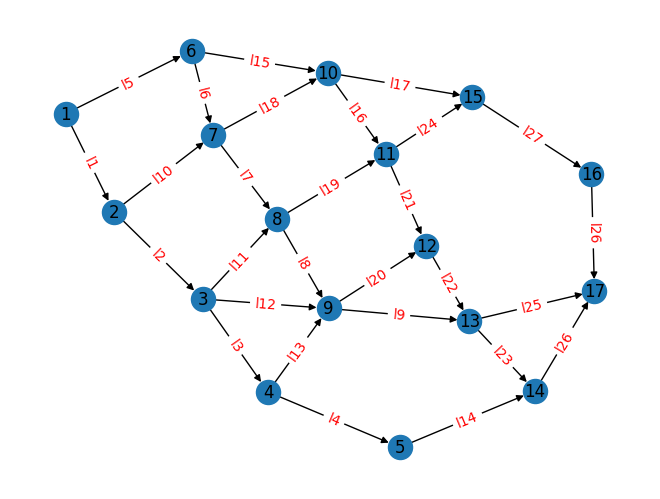

In [6]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels,
    font_color='red'
)
plt.axis('off')
plt.show()



##a
Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.

In [7]:
nx.shortest_path(G,1,17)

[1, 2, 3, 9, 13, 17]

In [8]:
n_edges = B.shape[1]
n_nodes = B.shape[0]
tau = 1
tmp = np.zeros(n_nodes)
tmp[0] = 1
tmp[-1] = -1
nu = tmp * tau
# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# In this case, the objective function is


# Construct the problem.
flow = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ flow)
constraints = [B @ flow == nu, flow >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `flow.value`.
path = np.around(flow.value, decimals=0, out=None)
print("Optimal flow array:",  path)
print("Optimal path:", [f"l{i[0]+1}" for i in list(np.argwhere(path==1))])

Optimal flow array: [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
Optimal path: ['l1', 'l2', 'l9', 'l12', 'l25']


Therefore, following the order of edges proposed in the graph, the optiaml path to travel from $(1)$ to $(17)$ is:

$$(1) -l_1 → (2) -l_2 →(3)-l_{12} →(9)-l_9→ (13)-l_{25}→(17)$$

## B
Find the maximum flow between node 1 and 17.

In [9]:
value, Gflow = nx.algorithms.flow.maximum_flow(G, 1, 17, capacity='capacity')

In [10]:
import pprint
found_flow = np.zeros(n_edges)
edge_list = [e for e in edges]
for el in Gflow:
  for x in Gflow[el]:
    t = tuple([el,x])
    index = edge_list.index(t)
    found_flow[index] = Gflow[el][x]

print("Max flow is: ", value)
print("With flow vector:",end=" ")
pprint.pp(list(found_flow))

Max flow is:  22448
With flow vector: [8741.0,
 13707.0,
 8741.0,
 0.0,
 0.0,
 0.0,
 8741.0,
 0.0,
 0.0,
 0.0,
 4624.0,
 9083.0,
 4624.0,
 0.0,
 4624.0,
 0.0,
 6297.0,
 7068.0,
 3835.0,
 10355.0,
 3835.0,
 825.0,
 8258.0,
 825.0,
 0.0,
 8258.0,
 7893.0,
 8258.0]


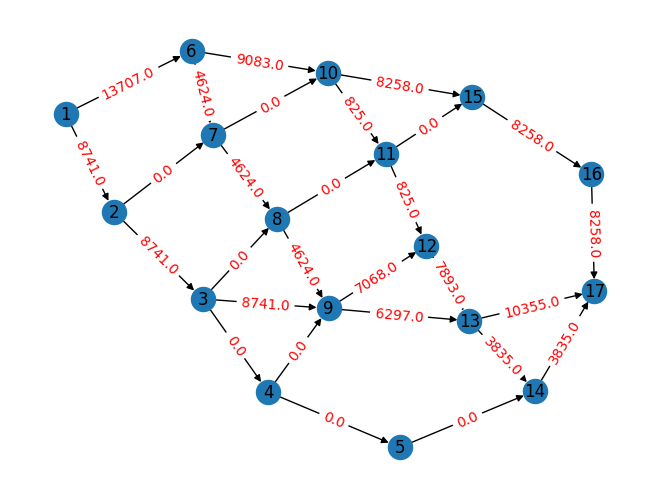

In [11]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(found_flow,edges)},
    font_color='red'
)
plt.axis('off')
plt.show()

## c
Given the flow vector in flow.mat, compute the vector $\nu$ satisfying $ Bf = \nu
$

In [12]:
# Compute net flow at each node
v = B @ f

# Compute inflows and outflows.
inflows = [max(flow_value, 0) for flow_value in v]
outflows = [min(flow_value, 0) for flow_value in v]

print("The vector v is:", v, "with total net flow =", sum(v)) # It satisfies the zero-sum constraint
print("The inflow relative to the given flow vector f is: v_+ =", inflows)
print("The outflow relative to the given flow vector f is: v_- =", outflows)


The vector v is: [ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544] with total net flow = 0
The inflow relative to the given flow vector f is: v_+ = [16282, 9094, 19448, 4957, 0, 4768, 413, 0, 0, 1169, 0, 0, 0, 0, 0, 0, 0]
The outflow relative to the given flow vector f is: v_- = [0, 0, 0, 0, -746, 0, 0, -2, -5671, 0, -5, -7131, -380, -7412, -7810, -3430, -23544]


## d

In [13]:

# exogenous flow vector: one unit of flow enters the origin and
# exits the destination node
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.
# In this case, the objective function is
# f_1^2 + f_2



# Construct the problem.
fe = cp.Variable(n_edges)
function = cp.sum(cp.multiply(cp.multiply(l,C),cp.inv_pos(1 - fe/C))- cp.multiply(l,C))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0, fe<=C]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()
# The optimal value for f is stored in `f.value`.
opt_flow = fe.value
print("Social optimal flow:", np.around(opt_flow, decimals=0, out=None))
print("Optimal cost:", np.around(cost_opt, decimals=2, out=None))
social_opt = fe


Social optimal flow: [6375. 5665. 2905. 2905. 9907. 4528. 2951. 2487. 3018.  709.    0. 2761.
    0. 2905. 5379. 2766. 4900. 2287.  463. 2230. 3229. 5459. 2307.    0.
 6170. 5212. 4900. 4900.]
Optimal cost: 23997.16


## e
Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function
$$
 min \sum_e \int_0^{f_e} \tau_e(s)~\mathrm{d}s.
$$

The solution of the expression:
$$
 min \sum_e \int_0^{f_e} \frac{l_e}{1 - \frac{s}{c_e}}~\mathrm{d}s.
$$
Is the objective function:
$$
\ min \sum_e -l_e c_e \ln\left(1 - \frac{f_e}{c_e}\right)
$$
Subject to constraints:
$$
 Bf = \nu, f \geq 0
$$

In [14]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

# Construct the problem
function = -cp.sum(cp.multiply(cp.multiply(C, l), cp.log(1 - cp.multiply(fe, cp.inv_pos(C)))))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned
result_w = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop equilibrium:", np.around(fe.value, decimals=1, out=None))

# Wardrop cost
wardrop_f = fe
wardrop_cost = sum(wardrop_f.value*l/(1 - wardrop_f.value/C))
print("Wardrop cost: ",  np.around(wardrop_cost, decimals=1, out=None))

Wardrop equilibrium: [6349.6 6178.2 2037.9 2037.9 9932.4 4567.2 2738.1 2144.1 3270.7  171.5
   69.2 4071.1    0.  2037.9 5365.1 2203.  5162.7 2000.6  663.2 2944.5
 2866.2 5810.7 2436.6    0.  6644.8 4474.5 5162.7 5162.7]
Wardrop cost:  24341.2


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## f

In [15]:
# exogenous flow vector: one unit of flow enters the origin and
# exits the destination node
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.


# Construct the problem.
fe = cp.Variable(n_edges)
d_prime = cp.multiply(cp.multiply(l,C),cp.inv_pos(cp.power((C - social_opt.value),2)))
omega = cp.multiply(social_opt.value,d_prime)
function = cp.sum(-cp.multiply(cp.multiply(C,l),cp.log(1-cp.multiply(fe,cp.inv_pos(C)))) + cp.multiply(fe,omega))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0, fe<=C]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result_w = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop equilibrium with tolls:", np.around(fe.value, decimals=2, out=None))
tolls_f = fe
wardrop_tolls_cost = sum(tolls_f.value*l/(1 - tolls_f.value/C))
print("Wardrop cost with tolls: ", wardrop_tolls_cost)


Wardrop equilibrium with tolls: [6373.02 5665.62 2904.65 2904.65 9908.98 4528.02 2950.25 2487.08 3018.06
  707.4     0.   2760.96    0.   2904.65 5380.96 2766.33 4899.81 2285.17
  463.17 2229.99 3229.49 5459.48 2307.48    0.   6170.06 5212.13 4899.81
 4899.81]
Wardrop cost with tolls:  23997.163018524214


## g

Instead of the total travel time, let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by
$$
\psi_e (f_e) = f_e (\tau_e (f_e)- l_e)
$$

*   Compute the system optimum $f^*$ for the costs above.



After multiplying, we obtain the expression:
$$
\psi_e (f_e) = f_e \tau_e (f_e)- f_e l_e
$$
From the numeral (d), we know:
$$
\sum_e f_e \tau_e(f_e) = \sum_e \left(\frac{l_e c_e}{1-\frac{f_e}{c_e}}-l_e c_e \right)
$$
The objective function will be:
$$
\psi_e (f_e) = min \sum_e \frac{l_e c_e}{1 - \frac{f_e}{c_e}} - l_e c_e - f_e l_e
$$
Subject to the constraints:
$$
 Bf = \nu, f \geq 0
$$

In [16]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

# Construct the problem, psi function
function = cp.sum(cp.multiply(cp.multiply(l,C),cp.inv_pos(1 - fe/C))- cp.multiply(l,C) - cp.multiply(fe,l))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned
result = prob.solve()

# The optimal value for f is stored in `f.value`.
print("System optimum f*:", np.around(fe.value, decimals=1, out=None))
print("Total cost = ", np.around(result, decimals=1))
new_soc_flow = fe
new_soc_opt_value = fe.value


System optimum f*: [6393.9 5420.8 3243.7 3243.7 9888.1 4530.6 3051.6 2612.1 2895.4  973.1
    0.  2177.1    0.  3243.7 5357.5 2969.8 4839.8 2452.1  439.5 1893.8
 3409.3 5303.  2140.2    0.  6058.3 5383.9 4839.8 4839.8]
Total cost =  13550.2


*   Construct a toll vector $\omega^* $ such that the Wardrop equilibrium
$ f^{(\omega^*)}$
coincides with $f^*$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(w^*)}$to verify your result.




The toll vector is defined as:
$$
  \omega_e^* = f_e^* \tau_e'(f_e^*)
$$

Having
$$
  \tau_e(f_e) = \frac{l_e}{1 - \frac{f_e}{c_e}}
$$
After the derivation, the expression is:
$$
  \tau_e'(f_e^*) = \frac{l_e c_e}{(c_e-f_e^*)^2}
$$
We also have that the objective function is:
$$
f^{(w^*)} =  min \sum_e \int_0^{f_e} \psi_e(s)~\mathrm{d}s + \omega_e^* f_e
$$

$$
f^{(w^*)} = min \sum_e -l_e c_e \ln\left(1 - \frac{f_e}{c_e}\right) - f_e l_e+ f_e \omega_e^*
$$

In [21]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

d_prime = cp.multiply(cp.multiply(l,C),cp.inv_pos(cp.power((C - new_soc_opt_value),2))) ##POR QUE USA LA DERIVADA DE TAU Y NO DE PSI??
omega = cp.multiply(new_soc_opt_value,d_prime)

function = cp.sum(-cp.multiply(cp.multiply(C,l),cp.log(1-cp.multiply(fe,cp.inv_pos(C)))) - cp.multiply(fe,l) + cp.multiply(fe,omega))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0, fe<=C]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
new_result_w = prob.solve()
print("New Wardrop equilibrium:", np.around(fe.value, decimals=1, out=None))
new_wardrop_f = fe
new_wardrop_cost = sum(new_wardrop_f.value*l/(1 - new_wardrop_f.value/C) - new_wardrop_f.value*l) ##NO ENTIENDO DE DONDE SALIO
print("New Wardrop cost: ",np.around (new_wardrop_cost, decimals = 1))

New Wardrop equilibrium: [6393.8 5420.8 3243.8 3243.8 9888.2 4530.8 3051.7 2612.  2895.3  973.
    0.  2177.     0.  3243.8 5357.4 2969.6 4839.8 2452.   439.7 1893.7
 3409.4 5303.  2140.2    0.  6058.2 5384.  4839.8 4839.8]
New Wardrop cost:  13550.2
